# Item based recommender

Up to this point we have been giving recommendations based on users: we create a user embedding from their past ratings, and in front of a new user to recommend to, we look at how other users with similar embeddings rate the movies that the tested subject hasn't seen yet.

Now we want to explore a different approach: recommend movies based on similarities between the already seen movies. This involves creating a movie embedding system.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from keras.utils import to_categorical
import umap
import matplotlib.pyplot as plt

from spotlight.datasets.movielens import get_movielens_dataset

In [2]:
dataset = get_movielens_dataset(variant='100K')
print(dataset)

<Interactions dataset (944 users x 1683 items x 100000 interactions)>


In [3]:
# Get metadata from movies
metadata = pd.read_csv('../datasets/movies_metadata_complet.csv')
metadata

,movie_id,movie_title,release_date,video_release_date,IMDb_URL,genres_name,avg_rating,min_rating,max_rating
0,1,Toy Story (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,"['Animation', ""Children's"", 'Comedy']",3.878318,1.0,5.0
1,2,GoldenEye (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,"['Action', 'Adventure', 'Thriller']",3.206107,1.0,5.0
2,3,Four Rooms (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,['Thriller'],3.033333,1.0,5.0
3,4,Get Shorty (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,"['Action', 'Comedy', 'Drama']",3.550239,1.0,5.0
4,5,Copycat (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),"['Crime', 'Drama', 'Thriller']",3.302325,1.0,5.0
...,...,...,...,...,...,...,...,...,...
1677,1678,Mat' i syn (1997),1998-02-06,NaN,http://us.imdb.com/M/title-exact?Mat%27+i+syn+...,['Drama'],1.000000,1.0,1.0
1678,1679,B. Monkey (1998),1998-02-06,NaN,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...,"['Romance', 'Thriller']",3.000000,3.0,3.0
1679,1680,Sliding Doors (1998),1998-01-01,NaN,http://us.imdb.com/Title?Sliding+Doors+(1998),"['Drama', 'Romance']",2.000000,2.0,2.0
1680,1681,You So Crazy (1994),1994-01-01,NaN,http://us.imdb.com/M/title-exact?You%20So%20Cr...,['Comedy'],3.000000,3.0,3.0


In [36]:
metadata = metadata.dropna(subset=['release_date'])

This movie metadata is quite limited. We could use more information about movies to generate better movie representations.

In [38]:
# Extract year from release date
metadata['release_year'] = pd.to_datetime(metadata['release_date']).dt.year
release_year_scaler = StandardScaler()
scaled_release_year = release_year_scaler.fit_transform(metadata[['release_year']])

/var/folders/dn/bvrxn2b545x6d3l2kn2qfrz80000gn/T/ipykernel_16226/552163019.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata['release_year'] = pd.to_datetime(metadata['release_date']).dt.year


In [40]:
# Flatten the list of genres and fit the OneHotEncoder
genres_flat = [genre for sublist in metadata['genres_name'] for genre in sublist]
genres_flat = np.array(genres_flat).reshape(-1, 1)

# OneHotEncoder from sklearn
ohencoder = OneHotEncoder()
encoded_genres = ohencoder.fit_transform(genres_flat)

# Reshape the encoded genres to match the movie-wise format (i.e., multiple genres per movie)
genre_matrix = []
for genres in metadata['genres_name']:
    genre_row = np.zeros(len(ohencoder.categories_[0]))
    for genre in genres:
        genre_index = ohencoder.categories_[0].tolist().index(genre)
        genre_row[genre_index] = 1
    genre_matrix.append(genre_row)

genre_matrix = np.array(genre_matrix)

In [41]:
# Normalize ratings (avg_rating, min_rating, max_rating)
rating_columns = ['avg_rating', 'min_rating', 'max_rating']
scaler = MinMaxScaler()
scaled_ratings = scaler.fit_transform(metadata[rating_columns])

In [42]:
scaled_ratings[0]

array([0.71957962, 0.        , 1.        ])

In [43]:
# Combine all preprocessed features
X = np.concatenate([scaled_ratings, scaled_release_year, genre_matrix], axis=1)

In [74]:
X_train, X_test = train_test_split(X, test_size=0.05, random_state=42)

In [ ]:
# Define the input size
input_size = X_train.shape[1]

# Define the encoding dimension (latent space size)
encoding_dim = 10  # You can adjust this based on your requirements

# Input layer
input_layer = Input(shape=(input_size,), name="Input")

# Encoder
encoded = Dense(20, activation='relu', name="Encoder_Hidden1")(input_layer)
encoded = Dense(encoding_dim, activation='relu', name="Latent_Space")(encoded)

# Decoder
decoded = Dense(20, activation='relu', name="Decoder_Hidden1")(encoded)
decoded = Dense(input_size, activation='sigmoid', name="Output")(decoded)

# Autoencoder model
autoencoder = Model(inputs=input_layer, outputs=decoded, name="Autoencoder")

# Compile the model
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Summary of the model
autoencoder.summary()

# Example data (you would replace this with your actual data)
# Assuming X is a numpy array with shape (num_samples, 40)

# Train the autoencoder
autoencoder.fit(X_train, X_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

Model: "Autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Encoder_Hidden1 (Dense)         │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Latent_Space (Dense)            │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Decoder_Hidden1 (Dense)         │ (None, 20)             │           220 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 40)             │           840 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,090 (8.16 KB)

 Trainable params: 2,090 (8.16 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2696 - val_loss: 0.2293
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step - loss: 0.2111 - val_loss: 0.1708
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step - loss: 0.1625 - val_loss: 0.1441
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step - loss: 0.1359 - val_loss: 0.1220
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step - loss: 0.1185 - val_loss: 0.1063
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step - loss: 0.1059 - val_loss: 0.0940
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step - loss: 0.0920 - val_loss: 0.0845
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step - loss: 0.0786 - val_loss: 0.0771
Epoch 9/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0758 - val_loss: 0.0726
Epoch 10/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0677 - val_loss: 0.0695
Epoch 11/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0704 - val_loss: 0.0663
Epoch 12/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step - loss:

In [76]:
# Save the encoder part of the model for feature extraction
encoder = Model(inputs=input_layer, outputs=encoded, name="Encoder")

In [86]:
# Retrieve embeddings (latent space representations)
embeddings = encoder.predict(X_train)

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 373us/step


In [81]:
metadata['genres_name']

0       ['Animation', "Children's", 'Comedy']
1         ['Action', 'Adventure', 'Thriller']
2                                ['Thriller']
3               ['Action', 'Comedy', 'Drama']
4              ['Crime', 'Drama', 'Thriller']
                        ...                  
1677                                ['Drama']
1678                  ['Romance', 'Thriller']
1679                     ['Drama', 'Romance']
1680                               ['Comedy']
1681                                ['Drama']
Name: genres_name, Length: 1681, dtype: object

/var/folders/dn/bvrxn2b545x6d3l2kn2qfrz80000gn/T/ipykernel_16226/3672703524.py:25: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=color_map, s=50, cmap='viridis')
/var/folders/dn/bvrxn2b545x6d3l2kn2qfrz80000gn/T/ipykernel_16226/3672703524.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


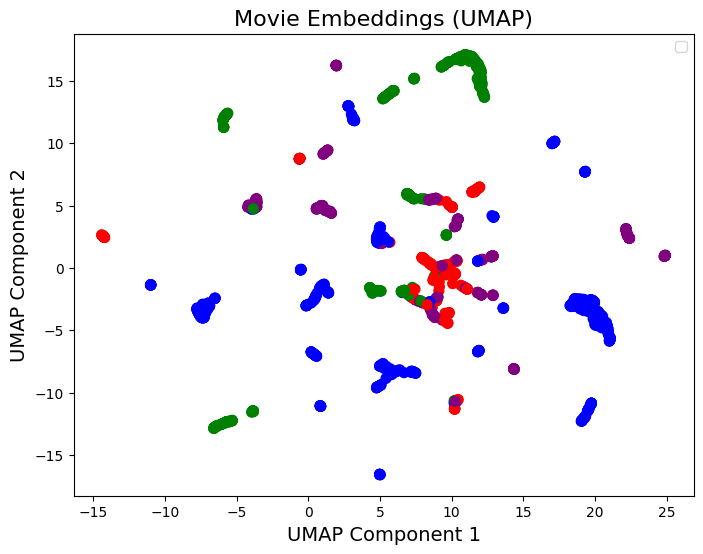

In [ ]:
# Reduce dimensionality using UMAP
reducer = umap.UMAP(n_components=2)
umap_embeddings = reducer.fit_transform(embeddings)

# Plotting the UMAP
plt.figure(figsize=(8, 6))

# Define colors for genres
genre_colors = ['red', 'blue', 'green']
genre_labels = metadata['genres_name']

# Create a color mapping based on genre
color_map = []
for genres in genre_labels:
    if 'Action' in genres:
        color_map.append('red')
    elif 'Drama' in genres:
        color_map.append('blue')
    elif 'Comedy' in genres:
        color_map.append('green')
    else:
        color_map.append('purple')

# Plot each point with its corresponding genre color
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=color_map, s=50, cmap='viridis')
plt.title('Movie Embeddings (UMAP)', fontsize=16)
plt.xlabel('UMAP Component 1', fontsize=14)
plt.ylabel('UMAP Component 2', fontsize=14)

# Show plot
plt.legend()
plt.show()

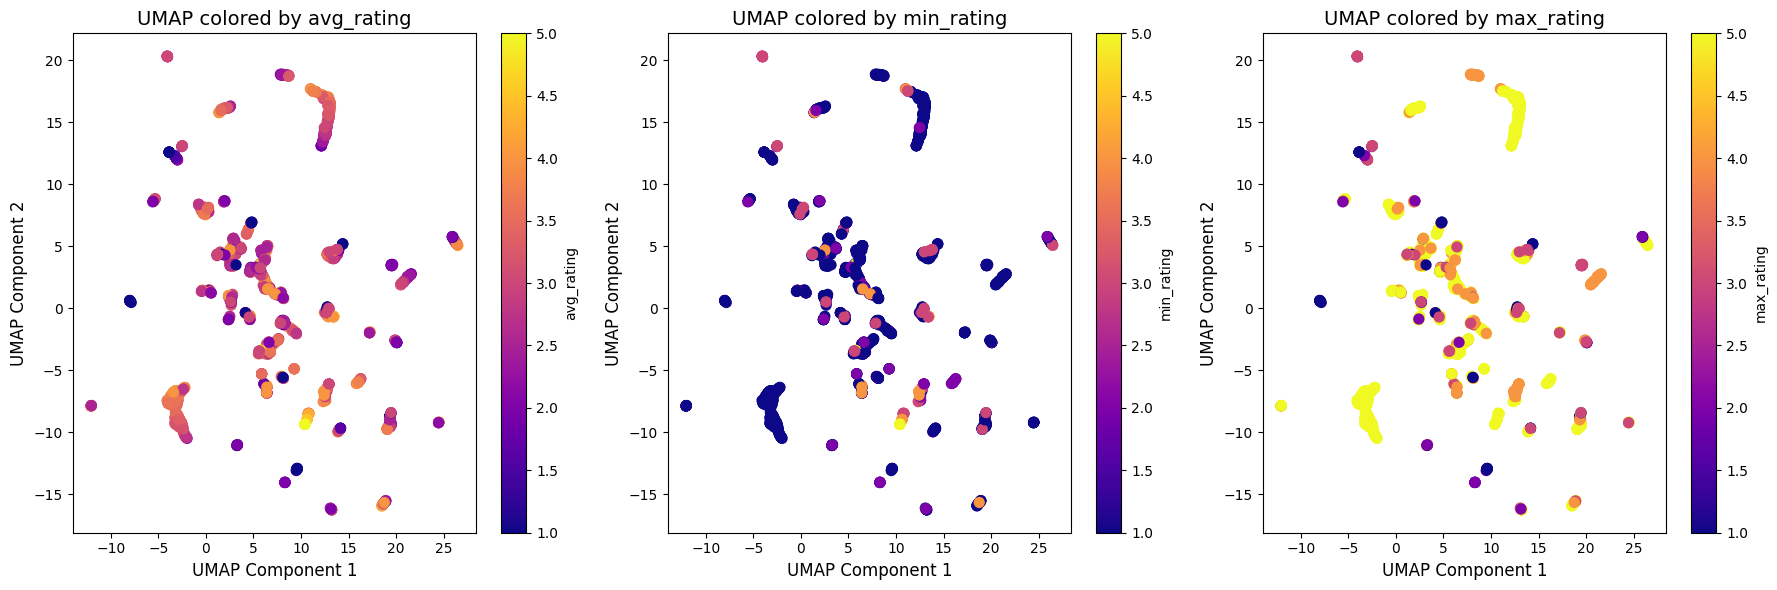

In [79]:
# Create a figure with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

color_variables = ['avg_rating', 'min_rating', 'max_rating']

# Loop through the variables and plot UMAPs
for i, var in enumerate(color_variables):
    color_map = metadata[var]

    # Plot UMAP on the corresponding subplot
    sc = axes[i].scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=color_map, s=50, cmap='plasma')

    # Add title, labels, and colorbar
    axes[i].set_title(f'UMAP colored by {var}', fontsize=14)
    axes[i].set_xlabel('UMAP Component 1', fontsize=12)
    axes[i].set_ylabel('UMAP Component 2', fontsize=12)
    fig.colorbar(sc, ax=axes[i], label=var)

# Adjust layout for better spacing
plt.tight_layout()

# Show plot
plt.show()

### Use trained encoder to recommend similar movies

In [99]:
# Encode testing samples
latent_new_samples = encoder.predict(X_test)
latent_new_sample = latent_new_samples[0]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [97]:
embeddings.shape

(1596, 10)

In [100]:
latent_new_sample.shape

(10,)

In [102]:
from sklearn.metrics.pairwise import euclidean_distances

# Compute Euclidean distances between the new sample and all samples
distances = euclidean_distances(latent_new_sample.reshape(1, -1), embeddings)

# Get the indices of the most similar samples (smallest distance)
k = 3 # if we want to get 3 most similar movies
most_similar_indices = distances.argsort()[0][:k]  # Get top k most similar samples

In [105]:
metadata.loc[most_similar_indices]

,movie_id,movie_title,release_date,video_release_date,IMDb_URL,genres_name,avg_rating,min_rating,max_rating,release_year
862,863,"Garden of Finzi-Contini, The (Giardino dei Fin...",1996-11-08,NaN,http://us.imdb.com/M/title-exact?Giardino%20de...,['Drama'],3.916667,2.0,5.0,1996
1543,1544,It Takes Two (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?It%20Takes%20...,['Comedy'],2.666667,1.0,4.0,1995
426,427,To Kill a Mockingbird (1962),1962-01-01,NaN,http://us.imdb.com/M/title-exact?To%20Kill%20a...,['Drama'],4.292237,1.0,5.0,1962
